# In-depth Analysis of the Blood Donation Dataset
### Joseph Petersen - Springboard Capstone 1

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

plt.style.use('ggplot')

In [2]:
# Read in the csv file
df = pd.read_csv('data/transfusion.csv')
# Rename the columns for clarity
df.columns = ['months_since_last', 'total_times_donated', 'total_cc_blood_donated', 'months_since_first', 
              'donated_march_2007']
# Calculate the frequency column
df['frequency'] = df.months_since_first / df.total_times_donated
# Reindex into a more logical structure
df = df.reindex(columns=['months_since_first', 'months_since_last', 'total_times_donated', 'total_cc_blood_donated', 
                         'frequency', 'donated_march_2007'])

df_wb = df.copy() # Dataframe with total blood intact
df = df.drop('total_cc_blood_donated', axis=1) # Dataframe without total blood
df_nf = df.drop('frequency', axis=1) # Dataframe without frequency
df_min = df.drop(['months_since_first', 'total_times_donated'], axis=1) # Dataframe just frequency and recency

In [3]:
# Examining the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
months_since_first     748 non-null int64
months_since_last      748 non-null int64
total_times_donated    748 non-null int64
frequency              748 non-null float64
donated_march_2007     748 non-null int64
dtypes: float64(1), int64(4)
memory usage: 29.3 KB


In [4]:
df.head()

,months_since_first,months_since_last,total_times_donated,frequency,donated_march_2007
0,98,2,50,1.960000,1
1,28,0,13,2.153846,1
2,35,1,16,2.187500,1
3,45,2,20,2.250000,1
4,77,1,24,3.208333,0


In [5]:
def adjusted_threshold(y_scores, t):

    # This function adjusts predictions or a probability array based on the threshold 't' value
    # It looks at the probability of the '1' in a binary response variable
    
    return [1 if y[1] >= t else 0 for y in y_scores]

def con_mat(model, X_train, X_test, y_train, y_test, y_pred):

    # This function takes  train/test and prediction data to produce a
    # graphed confusion matrix and classification report
    
    cm = confusion_matrix(y_test, y_pred)
    labels=['Non-Returners', 'Returners']
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of donated_march_2007')
    ttl = ax.title
    ttl.set_position([.5, 1.1])
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w", fontsize=24)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_test, y_pred))
    

## Model Testing

In [6]:
# Checking the distribution of the response variables
print("Distribution of response variable (full dataset):")
print(df.donated_march_2007.value_counts())
print("Mean:", df.donated_march_2007.mean())

Distribution of response variable (full dataset):
0    570
1    178
Name: donated_march_2007, dtype: int64
Mean: 0.23796791443850268


The response variable is unbalanced. Only about 24% of the response column is a returner (1) with the rest being non-returners (0). We're going to balance it by upsampling using `SMOTE`, but first we need to split the data into training/testing sets and scale the data for consistency. To reduce the influence of outliers, we'll use `RobustScaler`.

In [81]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('donated_march_2007', axis=1).values, 
                                             df.donated_march_2007.values, random_state=23, test_size=0.25)

print("Distribution of response variable (training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (training set):
0    425
1    136
dtype: int64
Mean: 0.24242424242424243


In [82]:
# Scaling the data, you fit on the training data then transform both the train and test set
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [83]:
# Transforming the train and test features with the scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
# Upsampling the training set
smt = SMOTE(random_state=23)
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (upscaled training set):
1    425
0    425
dtype: int64
Mean: 0.5


With the data now scaled and upsampled, we can move on to model testing.

In [85]:
# Instantiating the models and creating a function to test them all
logreg = LogisticRegression(solver='liblinear', random_state=23)
linsvm = LinearSVC(dual=False, random_state=23)
rfc = RandomForestClassifier(random_state=23)
svm_rbf = SVC(kernel='rbf')
svm_poly = SVC(kernel='poly')
knn = KNeighborsClassifier()

algs = {'LR': logreg,
        'LinSVM': linsvm,
        'RFC': rfc,
        'SVM_RBF': svm_rbf,
        'SVM_POLY': svm_poly,
        'KNN': knn}

perf_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'mae'], index = algs.keys())

def model_test(algs):
    
    # This function takes a dictionary an instantiated models
    # fits and places the scores in a dataframe
    
    for name, alg in algs.items():
        alg.fit(X_train, y_train)
        pred = alg.predict(X_test)
        mae = np.mean(abs(pred - y_test))
        
        
        perf_df.loc[name].accuracy = accuracy_score(y_test, pred)
        perf_df.loc[name].precision = precision_score(y_test, pred)
        perf_df.loc[name].recall = recall_score(y_test, pred)
        perf_df.loc[name].f1 = f1_score(y_test, pred)
        perf_df.loc[name].mae = mae
        

In [86]:
model_test(algs)

/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [87]:
# The model performance dataframe
perf_df

,accuracy,precision,recall,f1,mae
LR,0.641711,0.345679,0.666667,0.455285,0.358289
LinSVM,0.652406,0.358025,0.690476,0.471545,0.347594
RFC,0.700535,0.333333,0.333333,0.333333,0.299465
SVM_RBF,0.727273,0.418182,0.547619,0.474227,0.272727
SVM_POLY,0.486631,0.282258,0.833333,0.421687,0.513369
KNN,0.668449,0.314815,0.404762,0.354167,0.331551


Text(0, 0.5, 'MAE')

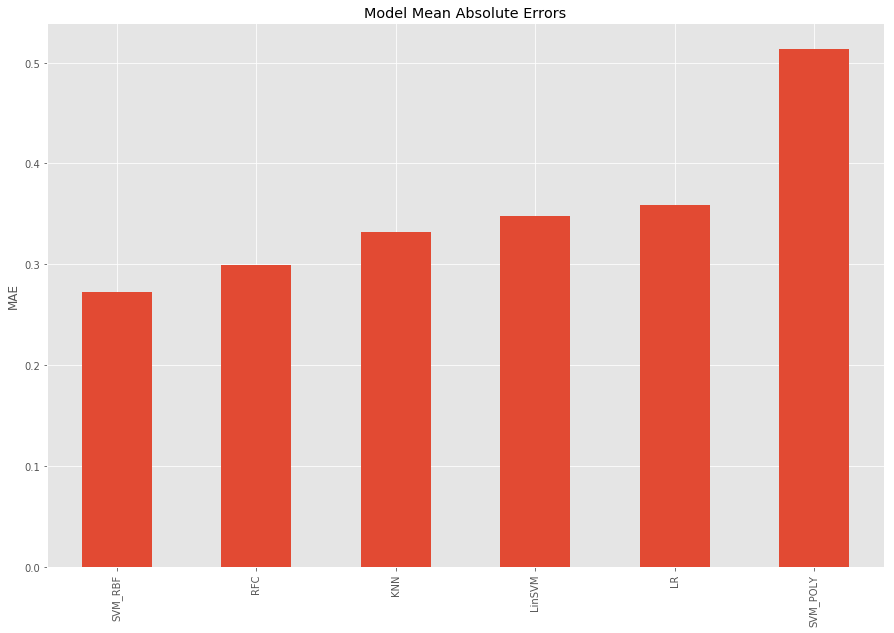

In [88]:
# Visualizing MAE
perf_df.mae.sort_values().plot(kind='bar', title='Model Mean Absolute Errors', figsize=[15,10])
plt.ylabel('MAE')

The `RandomForestClassifier` has the lowest mean absolute error, and having a low MAE is a good thing. However, we should look at recall as well as that's the primary metric by which we can measure success given the needs of the client.

Text(0, 0.5, 'Recall')

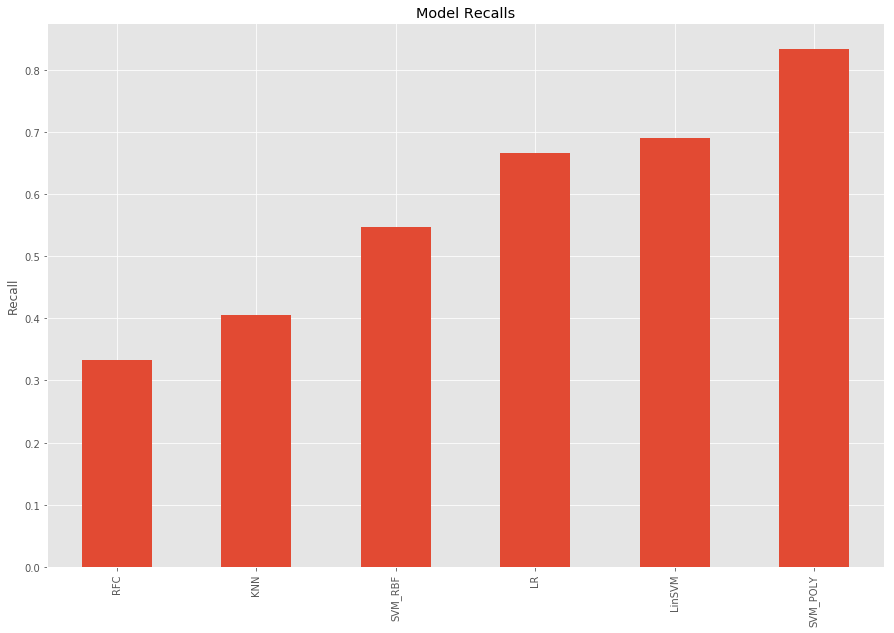

In [89]:
# Visualizing recall
perf_df.recall.sort_values().plot(kind='bar', title='Model Recalls', figsize=[15,10])
plt.ylabel('Recall')

The `LogisticRegression` and `LinearSVC` models are very similar across the board which isn't super surprising. The models are very similar as they only differ in the loss function. `LinearSVM` minimizes hinge loss while `LogisticRegression` minimizes logistic loss. In this case, we will move forward with tuning the parameters of the `LinearSVC` model as it has a good recall score and moderate mean absolute error. It also has a decent F1 score which balances precision and recall. We will use `GridSearchCV` to go over the training data in folds and test various parameters. We will score the search on recall in order to maximize that score given the clients needs.

In [95]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

linsvm = LinearSVC(random_state=23, dual=False)
linsvm_gs = GridSearchCV(linsvm, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
%time linsvm_gs.fit(X_train, y_train)

CPU times: user 59.5 ms, sys: 4.93 ms, total: 64.5 ms
Wall time: 182 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=23, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [96]:
print("Tuned SVM Parameters: {}".format(linsvm_gs.best_params_)) 
print("Best score: {}".format(linsvm_gs.best_score_))

Tuned SVM Parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.7129411764705882


In [98]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]}

linsvm = LinearSVC(dual=False, random_state=23)
linsvm_gs = GridSearchCV(linsvm, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
%time linsvm_gs.fit(X_train, y_train)

CPU times: user 51.3 ms, sys: 3.84 ms, total: 55.2 ms
Wall time: 164 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=23, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [99]:
print("Tuned SVM Parameters: {}".format(svm_gs.best_params_)) 
print("Best score: {}".format(svm_gs.best_score_))

Tuned SVM Parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.7129411764705882


[[92 53]
 [13 29]]


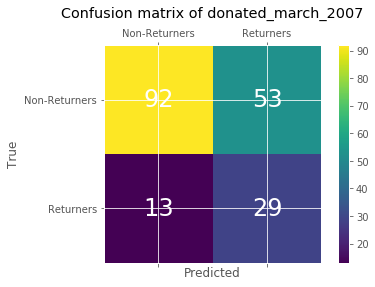

              precision    recall  f1-score   support

           0       0.88      0.63      0.74       145
           1       0.35      0.69      0.47        42

   micro avg       0.65      0.65      0.65       187
   macro avg       0.61      0.66      0.60       187
weighted avg       0.76      0.65      0.68       187



In [101]:
best_linsvm = LinearSVC(dual=False, random_state=23, C=0.1, penalty='l2')
best_linsvm.fit(X_train, y_train)

y_pred = best_linsvm.predict(X_test)
con_mat(best_linsvm, X_train, X_test, y_train, y_test, y_pred)

### Trying Smaller Dataset

In [29]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df_min.drop('donated_march_2007', axis=1).values, 
                                             df_min.donated_march_2007.values, random_state=23, test_size=0.25)

print("Distribution of response variable (training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (training set):
0    425
1    136
dtype: int64
Mean: 0.24242424242424243


In [30]:
# Scaling the data, you fit on the training data then transform both the train and test set
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [31]:
# Transforming the train and test features with the scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Upsampling the training set
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (upscaled training set):
1    425
0    425
dtype: int64
Mean: 0.5


With the data now scaled and upsampled, we can move on to model testing.

In [34]:
model_test(algs)

/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [35]:
# The model performance dataframe
perf_df

,accuracy,precision,recall,f1,mae
LR,0.641711,0.349398,0.690476,0.464,0.358289
LinSVM,0.631016,0.341176,0.690476,0.456693,0.368984
RFC,0.73262,0.375,0.285714,0.324324,0.26738
SVM_RBF,0.636364,0.341463,0.666667,0.451613,0.363636
SVM_POLY,0.433155,0.257576,0.809524,0.390805,0.566845
KNN,0.700535,0.365385,0.452381,0.404255,0.299465


Text(0, 0.5, 'MAE')

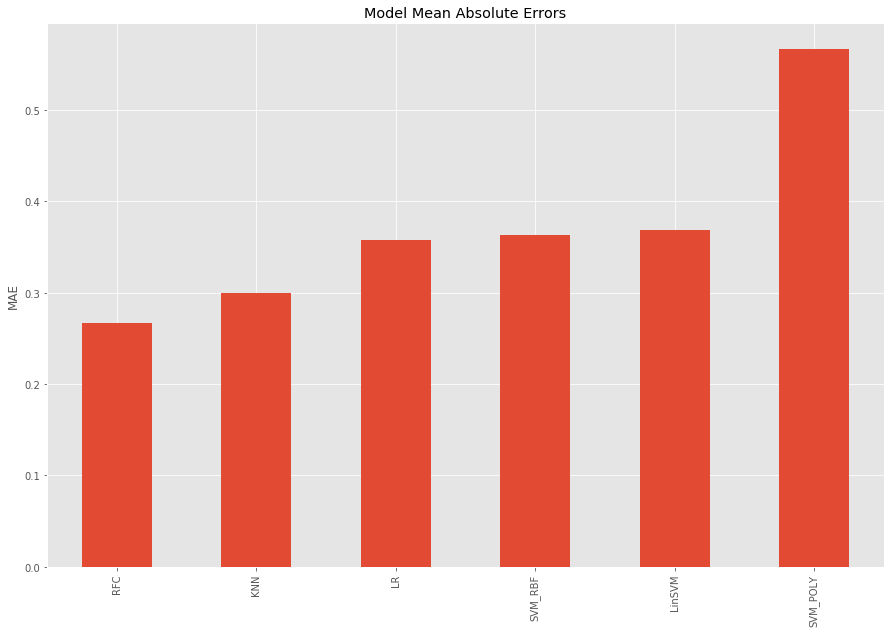

In [36]:
# Visualizing MAE
perf_df.mae.sort_values().plot(kind='bar', title='Model Mean Absolute Errors', figsize=[15,10])
plt.ylabel('MAE')

The `RandomForestClassifier` has the lowest mean absolute error, but we should look at recall as well as that's the primary metric by which we can measure success given the needs of the client.

Text(0, 0.5, 'Recall')

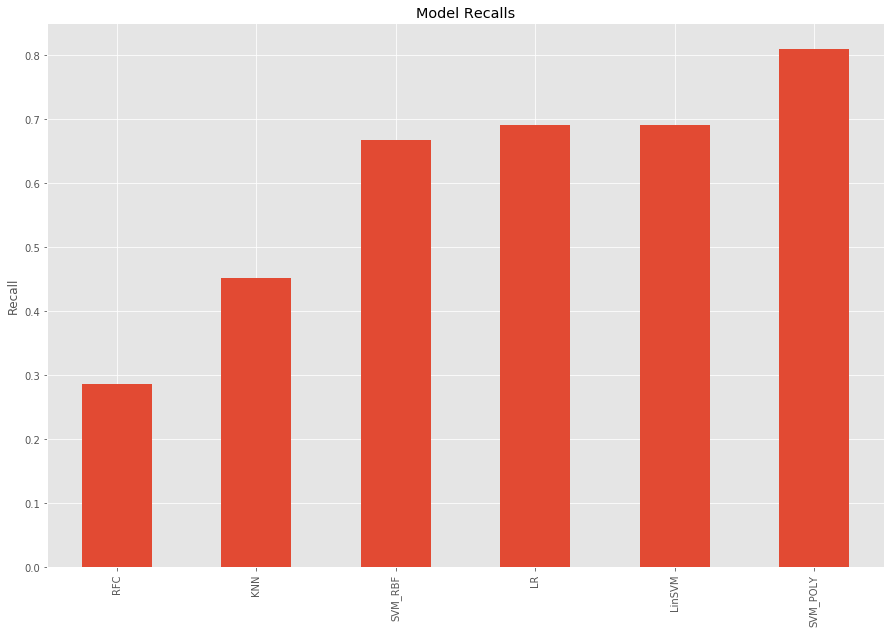

In [37]:
# Visualizing recall
perf_df.recall.sort_values().plot(kind='bar', title='Model Recalls', figsize=[15,10])
plt.ylabel('Recall')

In [43]:
param_grid = {'C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2']}

lr = LogisticRegression(solver='liblinear', random_state=23)
lr_gs = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
%time lr_gs.fit(X_train, y_train)

CPU times: user 66.5 ms, sys: 4.11 ms, total: 70.6 ms
Wall time: 141 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=23, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [44]:
print("Tuned LR Parameters: {}".format(lr_gs.best_params_)) 
print("Best score: {}".format(lr_gs.best_score_))

Tuned LR Parameters: {'C': 0.1, 'penalty': 'l1'}
Best score: 0.7188235294117648


In [45]:
param_grid = {'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1.1, 1.2, 1.3, 1.4, 1.5],
              'penalty': ['l1', 'l2']}

lr = LogisticRegression(solver='liblinear', random_state=23)
lr_gs = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
%time lr_gs.fit(X_train, y_train)

CPU times: user 69.1 ms, sys: 4.15 ms, total: 73.2 ms
Wall time: 166 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=23, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1.1, 1.2, 1.3, 1.4, 1.5], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [46]:
print("Tuned LR Parameters: {}".format(lr_gs.best_params_)) 
print("Best score: {}".format(lr_gs.best_score_))

Tuned LR Parameters: {'C': 0.05, 'penalty': 'l1'}
Best score: 0.7188235294117648


In [47]:
param_grid = {'C': [0.01, 0.02, 0.03, 0.04, 0.05],
              'penalty': ['l1', 'l2']}

lr = LogisticRegression(solver='liblinear', random_state=23)
lr_gs = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
%time lr_gs.fit(X_train, y_train)

CPU times: user 42.1 ms, sys: 3.51 ms, total: 45.6 ms
Wall time: 131 ms


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=23, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [48]:
print("Tuned LR Parameters: {}".format(lr_gs.best_params_)) 
print("Best score: {}".format(lr_gs.best_score_))

Tuned LR Parameters: {'C': 0.04, 'penalty': 'l1'}
Best score: 0.7188235294117648


[[91 54]
 [14 28]]


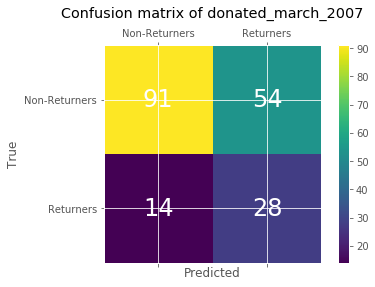

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       145
           1       0.34      0.67      0.45        42

   micro avg       0.64      0.64      0.64       187
   macro avg       0.60      0.65      0.59       187
weighted avg       0.75      0.64      0.67       187



In [50]:
best_lr = LogisticRegression(solver='liblinear', random_state=23, C=0.04, penalty='l1')
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)
con_mat(best_lr, X_train, X_test, y_train, y_test, y_pred)

[[88 57]
 [12 30]]


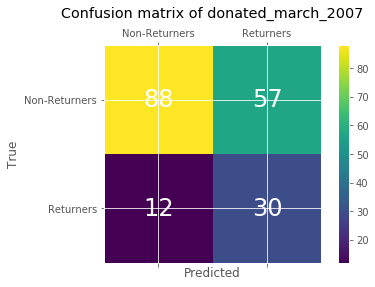

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       145
           1       0.34      0.71      0.47        42

   micro avg       0.63      0.63      0.63       187
   macro avg       0.61      0.66      0.59       187
weighted avg       0.76      0.63      0.66       187



In [74]:
y_pred = best_lr.predict_proba(X_test)
y_pred_adj = adjusted_threshold(y_pred, 0.47)

con_mat(best_lr, X_train, X_test, y_train, y_test, y_pred_adj)

In [76]:
best_lr.coef_

array([[-0.83837838, -0.63235723]])